In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('preprocessing')
import numpy as np
import pandas as pd
import torch
from math import floor
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle as pkl
import data
import interpret
import neural_networks
from sklearn.decomposition import DictionaryLearning, NMF

# prepare data

In [2]:
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
dsets = ['clath_aux+gak_a7d2']
splits = ['train', 'test']

meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']

try:
    df = pd.read_pickle('data/df_py36.pkl')
    df_test = pd.read_pickle('data/df_test_py36.pkl')
except:
    dfs, _ = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta)
    df = dfs[('clath_aux+gak_a7d2', 'train')]
    df.to_pickle('data/df.pkl')
    df_test = dfs[('clath_aux+gak_a7d2', 'test')]
    df_test.to_pickle('data/df_test.pkl')

# load model
results = pkl.load(open('models/dnn_full_long_normalized_across_track_1_feat.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=0, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# training data

# input to the model (n x 40)
X = np.vstack([x for x in df[track_name].values])
# input before normalization, can be used for interpretation (n x 40)
X_unnormalized = np.vstack([x for x in df[track_name_unnormalized].values])
y = df['y_consec_thresh'].values

# test data
# input to the model (n x 40)
X_test = np.vstack([x for x in df_test[track_name].values])
# input before normalization, can be used for interpretation (n x 40)
X_unnormalized_test = np.vstack([x for x in df_test[track_name_unnormalized].values])
y_test = df_test['y_consec_thresh'].values

In [3]:
print('shapes train', X.shape, X_unnormalized.shape, y.shape)
print('shapes test', X_test.shape, X_unnormalized_test.shape, y_test.shape)

shapes train (2936, 40) (2936, 40) (2936,)
shapes test (1005, 40) (1005, 40) (1005,)


# example tracks

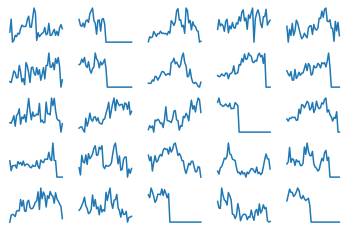

In [4]:
R, C = 5, 5
for i in range(25):
    plt.subplot(R, C, i + 1)
    plt.plot(X[i])
    plt.axis('off')

# dictionary learning on tracks

In [11]:
def plot_comps(comps):
    R, C = 3, 4
    for i in range(comps.shape[0]):
        plt.subplot(R, C, i + 1)
        vmax = np.max(comps)
        vmin = np.min(comps)
        plt.plot(comps[i])
        plt.ylim((vmin - 1, vmax + 1))
        plt.axis('off')
    plt.show()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DictionaryLearning from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


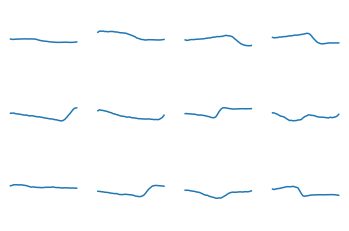

In [12]:
# sparse coding can take a while...
n_comps = 12
alpha = 1
try:
    d = pkl.load(open(f'models/sc_{n_comps}_alpha={alpha}.pkl', 'rb'))
except:
    d = DictionaryLearning(n_components=n_comps, alpha=alpha, random_state=42)
    d.fit(X)
    pkl.dump(d, open(f'models/sc_{n_comps}_alpha={alpha}.pkl', 'wb'))
plot_comps(d.components_)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


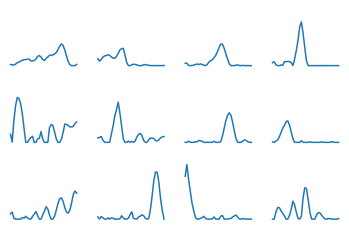

In [13]:
n_comps=12
d = NMF(n_components=n_comps, random_state=42)
d.fit(X - np.min(X))
# pkl.dump(d, open(f'models/nmf_{n_comps}.pkl', 'wb'))
plot_comps(d.components_)

# interpret one pred at multiple scales
Calculates cd score for segments of different lengths. (e.g. each time point, half of inputs, etc.)

Note: input is length 40. Sometimes input time-series are shorter than this, so they are padded with zeros at the end. Sometimes inputs are longer than 40, but then they are downsampled to length 40. Later we might want to consider using the full-length tracks.

Note: the model predicts a single continuous value (it was trained using an auxiliary regression outcome). The more positive the output, the higher the probability of predicting class "1". When the prediction is > 0, then the output is predicting class 1 and when it is < 0, it is a prediction for class 0.

In [14]:
num = 0
xtrack = X[num: num + 1]
xtrack_unnormalized = X_unnormalized[num: num + 1]
xtrack_t = torch.tensor(np.array(list(xtrack)), dtype=torch.float)
pred = dnn.model(xtrack_t, None).item()

In [ ]:
# calculate cd scores for different subsegments of the input
T = 40 # seq len
# track_segs = [(s, s + 1) for s in range(T)]
DIV = 40
track_segs_fourty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]

DIV = 20
track_segs_twenty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 10
track_segs_tenths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 6
track_segs_fifths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 4
track_segs_quarters = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 1
track_segs_full = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
track_segs_list = [track_segs_fourty, track_segs_twenty, track_segs_tenths,
                   track_segs_fifths, track_segs_quarters, track_segs_full]
cd_scores_list = [[interpret.calc_cd_score(xtrack_t, None, s, e, dnn.model)
                  for (s, e) in track_segs]
                  for track_segs in tqdm(track_segs_list)]

  0%|          | 0/6 [00:00<?, ?it/s]

ValueError: 'c' argument has 1 elements, which is not acceptable for use with 'x' with size 1, 'y' with size 1.

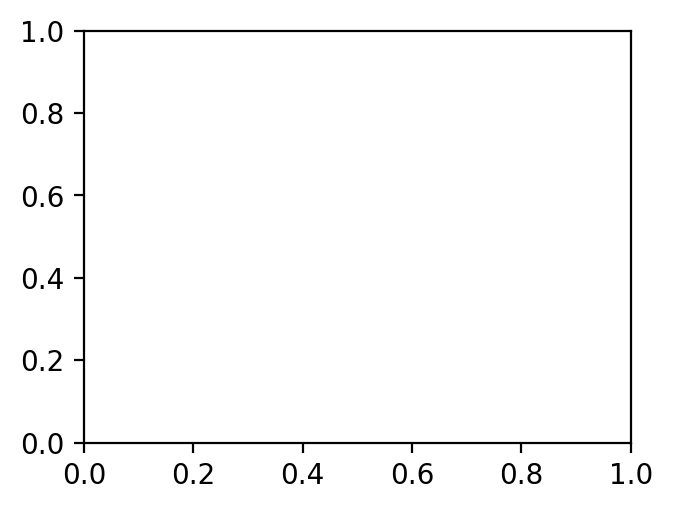

In [10]:
plt.figure(dpi=200, figsize=(12, 6))
R, C = 2, 3
for i, track_segs in enumerate(track_segs_list):
    ax = plt.subplot(R, C, i + 1)
    cd_scores = cd_scores_list[i]
    interpret.plot_segs(track_segs, cd_scores, xtrack_unnormalized[0]) #, pred, y=0)
    
    if i == C * (R - 1):
        plt.xlabel('Time')
    else:
        plt.xticks([])
    if i == 0:
        plt.ylabel('Clath Amplitude')
    else:
        plt.yticks([])
    if i ==  C * R - 1:
        plt.text(0.1, 0.9,
                 f'pred: {pred:.2f}, y: {1 * y[num]}', fontsize='x-large', transform = ax.transAxes)
plt.tight_layout()
plt.show()